In [1]:
from pprint import PrettyPrinter 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pp = PrettyPrinter(indent=4)

# Investigation of the _Synchronized Brainwave Dataset_

Data set URL: [https://www.kaggle.com/berkeley-biosense/synchronized-brainwave-dataset/version/2](https://www.kaggle.com/berkeley-biosense/synchronized-brainwave-dataset/version/2)

The data set consists of EEG readings, using a one-channel consumer EEG device called [NeuroSky](http://neurosky.com/), from 30 participants. Two slightly different stimuli were presented to two (mutual exclusive) groups of 15 participants each. The two stiumuli were videos accompanied with voice instructions presenting different tasks, interleaved with phases of relaxation (with eyes shut) and hearing music.
The data from the EEG head bands was collected on a central server that keept track of the latency so that later the **synchronized timestamps** could be computed. Each row in the `eeg-data.csv` file represents one data packet recieved by the server.

## Exploration of the data set

### Basic properties shape, size and columns

We started with an exploration of the data's shape, the columns, their semantics as stated in the documentation and the data types.

In [2]:
data = pd.read_csv('data/eeg-data.csv')
data.shape

(30013, 13)

We see that the data set has 13 columns and in total ~30K rows that, according to the description, represent one measurment submitted to the central server. 

To display the column names in a nice list we use a Python list comprehension so we don't need to write a for-loop

In [3]:
def print1D(a):
    _ = [print(name) for name in a]
    
print1D(data.columns.values)

Unnamed: 0
id
indra_time
browser_latency
reading_time
attention_esense
meditation_esense
eeg_power
raw_values
signal_quality
createdAt
updatedAt
label


There are several fields that are of interest for the further investigation:
1. `indra_time`: the time of the measurement synchronized over the participants in one group
2. `attention_esense`: a measure of the participants attention in the measurment period (\*)
3. `meditation_esense`: a measurment of the participants relaxation in the measurment period (\*)
4. `eeg_power`: an array of six values representing the relative strength of the signal in the eight common EEG-frequency bands (\*\*)
5. `raw_values`: an array of the raw values the device measured during the measrement period
6. `signal_quality`: a measure of the quality of the measurement (0=optimal, >128=device misplaced)
7. `label`: pahse of the experiment the measurement was taken in

(\*) These two values are computed using a unknown proprietary algorithm

(\*\*) Citing the documentation: _"These values have no units and are only meaningful for comparison to the values for the other frequency bands within a sample."_

The `eeg_power` field seemed interesting. The documentation states that this fields contains an array with eight values representing the **relative strength** of the signal in the eight commonly recognized frequency bands (delta (0.5 - 2.75Hz), theta (3.5 - 6.75Hz), low-alpha (7.5 - 9.25Hz), high-alpha (10 - 11.75Hz), low-beta (13 - 16.75Hz), high-beta (18 - 29.75Hz), low-gamma (31 - 39.75Hz), and mid-gamma (41 - 49.75Hz)). But as stated in the comment above they can only be used for comparison within a sample. This poses a problem for an analyses of the data. For one participant over time, as well as a comparison between participants in and accross the two experimental groups. We have been thinking about a way to compare the distribution of relative signal strengths, but we could not find a way to make the distributions comparable in a plausible way. 

In the end we went on with further analysis using the `meditation_esense` and `attention_esense` pair of values and the `raw_values` which hold the actual EEG signal. Both are explained in more detail in the respective sections.


### How balanced is the number of measurements over the participants?

Inspecting the shape of the data we get the intuition that we could have around 1000 readings per participant. We can test this using Panda's `value_counts()` function on the id-column

In [4]:
print(data['id'].value_counts())
print(f"\nTotal samples: {data.shape[0]}")

17    1607
12    1495
2     1493
8     1465
5     1462
4     1388
14    1297
9     1268
15    1263
10    1224
13    1217
3     1197
28    1180
6     1168
29    1140
11     994
1      940
19     867
7      775
24     688
22     639
20     628
26     623
30     616
25     612
16     606
18     580
23     569
27     548
21     464
Name: id, dtype: int64

Total samples: 30013


This shows that our assumption of roughly a thousand measurments per participant was not correct, there are differences in the number of measurements per participant: from under 500 to around 1500 measurments.

### Is the label data even usefull?

A preview of the data in the table can be displayed using the `head` and `tail` functions

In [5]:
data.head(5)

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
0,3730,12,2015-05-09 23:13:42.281,1461,2015-05-09 16:13:40.954,0,0,"[944412.0, 111373.0, 52404.0, 28390.0, 3237.0,...","[-203.0, -202.0, -196.0, -185.0, -163.0, -137....",200,2015-05-09 23:13:39.550,2015-05-09 23:13:39.549+00,unlabeled
1,3732,12,2015-05-09 23:13:43.186,1461,2015-05-09 16:13:41.964,0,0,"[1793049.0, 89551.0, 3896.0, 21727.0, 9301.0, ...","[104.0, 134.0, 128.0, 121.0, 145.0, 151.0, 123...",200,2015-05-09 23:13:40.559,2015-05-09 23:13:40.559+00,unlabeled
2,3734,12,2015-05-09 23:13:44.392,1461,2015-05-09 16:13:42.950,0,0,"[400192.0, 640624.0, 153087.0, 69733.0, 98854....","[2002.0, 2047.0, 2047.0, 2047.0, 2047.0, 2047....",200,2015-05-09 23:13:41.549,2015-05-09 23:13:41.549+00,unlabeled
3,3735,12,2015-05-09 23:13:45.297,1461,2015-05-09 16:13:43.935,0,0,"[681192.0, 138630.0, 67891.0, 26459.0, 592240....","[1287.0, 1241.0, 1196.0, 1155.0, 1113.0, 1072....",200,2015-05-09 23:13:42.532,2015-05-09 23:13:42.532+00,unlabeled
4,3737,12,2015-05-09 23:13:46.201,1460,2015-05-09 16:13:44.936,0,0,"[268406.0, 197772.0, 190654.0, 266433.0, 91683...","[1905.0, 1836.0, 1770.0, 1707.0, 1645.0, 1587....",200,2015-05-09 23:13:43.532,2015-05-09 23:13:43.532+00,unlabeled


In [6]:
data.tail(5)

,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
30008,10584,17,2015-05-10 00:05:50.380,34,2015-05-09 17:05:51.141,0,0,"[477547.0, 152641.0, 5145.0, 9858.0, 39852.0, ...","[57.0, 12.0, 9.0, 33.0, 50.0, 66.0, 64.0, 52.0...",200,2015-05-10 00:05:51.162,2015-05-10 00:05:51.162+00,unlabeled
30009,10589,17,2015-05-10 00:05:51.389,34,2015-05-09 17:05:52.134,0,0,"[388959.0, 48072.0, 11231.0, 14509.0, 25687.0,...","[21.0, -56.0, -37.0, 25.0, 56.0, 49.0, 23.0, 5...",200,2015-05-10 00:05:52.161,2015-05-10 00:05:52.161+00,unlabeled
30010,10590,17,2015-05-10 00:05:52.366,34,2015-05-09 17:05:53.120,0,0,"[53357.0, 18929.0, 11169.0, 11818.0, 20640.0, ...","[42.0, -4.0, -19.0, 19.0, 53.0, 44.0, 16.0, 4....",200,2015-05-10 00:05:53.144,2015-05-10 00:05:53.144+00,unlabeled
30011,10587,17,2015-05-10 00:05:53.382,34,2015-05-09 17:05:54.142,0,0,"[40891.0, 108300.0, 19622.0, 14285.0, 11863.0,...","[4.0, -24.0, -19.0, 24.0, 55.0, 65.0, 67.0, 58...",200,2015-05-10 00:05:54.167,2015-05-10 00:05:54.167+00,unlabeled
30012,10591,17,2015-05-10 00:05:54.645,34,2015-05-09 17:05:55.140,0,0,"[61861.0, 11302.0, 8251.0, 8788.0, 42668.0, 88...","[-35.0, -81.0, -62.0, 7.0, 80.0, 105.0, 97.0, ...",200,2015-05-10 00:05:55.165,2015-05-10 00:05:55.165+00,unlabeled


From the head and tail resulst we got the impression that the `label` field could contain only the value "unlabeled". We used the `unique` function to test this

In [7]:
print1D( data['label'].unique() )

unlabeled
blinkInstruction
blink1
blink2
blink3
blink4
blink5
relaxInstruction
relax
mathInstruction
math1
math2
math3
math4
math5
math6
math7
math8
math9
math10
math11
math12
musicInstruction
music
videoInstruction
video-ver1
thinkOfItemsInstruction-ver1
thinkOfItems-ver1
colorInstruction1
colorInstruction2
readyRound1
colorRound1-1
colorRound1-2
colorRound1-3
colorRound1-4
colorRound1-5
colorRound1-6
readyRound2
colorRound2-1
colorRound2-2
colorRound2-3
colorRound2-4
colorRound2-5
colorRound2-6
readyRound3
colorRound3-1
colorRound3-2
colorRound3-3
colorRound3-4
colorRound3-5
colorRound3-6
readyRound4
colorRound4-1
colorRound4-2
colorRound4-3
colorRound4-4
colorRound4-5
colorRound4-6
readyRound5
colorRound5-1
colorRound5-2
colorRound5-3
colorRound5-4
colorRound5-5
colorRound5-6
video-ver2
thinkOfItemsInstruction-ver2
thinkOfItems-ver2


The result showed that there are indeed different values in the label column. The description of the data set says that the `label` field contains a label indicating which phase of the stimulus was presented before the measurement was taken. "Unlabeled" are measurements take before and after the stimulus was presented (according to the documentation). 

### Is the signal quality mostly bad?

Another observation we made when looking into the data with `tail` and `head` functions was that all values of the field `signal_quality` are 200. The documentation says that a value of 0 indicates a good signal quality, 128 and more indicate that the participant was wearing the headband in an incorrect way. This was a reason for us investigating the distribution on the `singal_quality` values in the whole dataset. 

We therefor computed the value histogram for the `signal_quality` field. First we used `nunique` to find out the number of different values.

In [8]:
n_bins = data['signal_quality'].nunique()
n_bins

12

Since there are only 12 unique values in this field, we can compute a histogram showing the frequency of all values (not groupingcollecting in bins) using Pandas `hist` function or Seaborn's `histplot` function

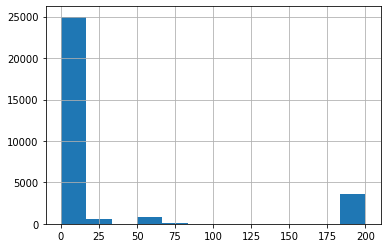

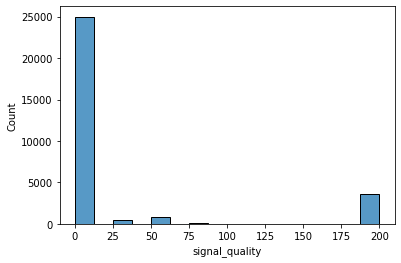

In [9]:
data['signal_quality'].hist(bins=n_bins)
      
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.histplot(data=data, x='signal_quality', ax=ax)

The histogram shows that the situation is actually not so bad. With the `unique` and `value_counts` function we can find out the frequency of the values and compute the percentage for each value.

In [10]:
total = data.shape[0]                          # get total number of rows
values = data['signal_quality'].unique()       # get the individual values
counts = data['signal_quality'].value_counts() # get the counts of all values
for i in range(len(sorted(values))):                   # loop trough all values
    value = counts.index[i]                    # get the value's count
    percentage = counts[value] / total * 100   # compute percentage
    print(f"{value}: {percentage:.2f}%") 

0: 83.27%
200: 11.84%
51: 2.49%
26: 0.90%
25: 0.78%
80: 0.46%
54: 0.18%
29: 0.05%
55: 0.01%
27: 0.01%
78: 0.01%
52: 0.01%


This result shows that actually 83% of the measurments are of good quality. Only around 12% are of bad quality. And all other measurements are under the threshold of 128.

## Attention and Meditation ESENSE

The data set contains two fields `meditation_esense` and `attention_esense`. These are two values computed by the NeuroSky SDK via propriatary algorithms that are not disclosed to the public. However, we found a [whitepaper by NeuroSky about the ESENSE feature](https://puzzlebox.io/orbit/development/raw-attachment/wiki/ArduinoThinkGearProcessing/neurosky_esense_whitepaper.pdf) (third-party source because the NeuroSky website is not available anymore). The whitepaper states: "[The] 'Attention' meter values, which indicate the user’s level of mental focus, and 'Meditation' meter values, which indicate the level of a user’s mental calmness." We also found that "These measures are trade secrets and cannot be described here".

A straight-forward hypothesis that can be formulated in the light of the description of the semantics of the two values is the following: High attention values and low meditation values could be observed during tasks that yield cognitive load in contrast to tasks where the participant is instructed to do nothing or to relax. In the later condition the opposite could be observed: low attention values and high meditation values. 

### Selection and filtering of data

To investigate our hypothesis we filter out subsets of the dataset. 
1. Samples from a relaxing conditions (`relax` and `music`)
2. Samples from conditions that yield increased cogntive load (`colorRound`* and `math`)

(*) The `colorRound` condition also included the instruction to count at a fast pace.

We created the following new DataFrames:
- _cond_relax_ - all samples with `label=="relax"`
- _cond_music_ - all samples with `label=="music"`
- _cond_task1_ - all samples with `label` starting with `"colorRound"`
- _cond_task2_ - all samples with `label` starting with `"math"`

In [11]:
cond_relax = data[data["label"] == "relax"]
cond_music = data[data["label"] == "music"]
cond_task1 = data[data["label"].str.startswith("colorRound", na=False)]
cond_task2 = data[data["label"].str.startswith("math", na=False)]

We then combined the passive and the task conditions into two DataFrames:
- _cond_passive_ - relax + music
- _cond_active_ - task1 + task2

In [12]:
cond_passive = pd.concat([
    cond_relax,
    cond_music
])

cond_active = relax = pd.concat([
    cond_task1,
    cond_task2
])

### Getting an overview

Because the description of the semantics auf `meditation_esense` and `attention_esense` sounded somewhat orthogonal and we have two finite scales here (both [0..100]) we had the idea to do a two-dimensional scatter plot for each of the conditions described above to gain an overview on the disribution of data points. 

If our hypothesis was holding we should see clusters of data points in the upper left quadrant for the passive conditions (high meditation, low attention) and cluster of data points in the lower right quadrant for the active conditions (low meditation, high attention).

We plotted a scatterplot with `meditation_esense` and `attention_esense` as the axes for the four conditions

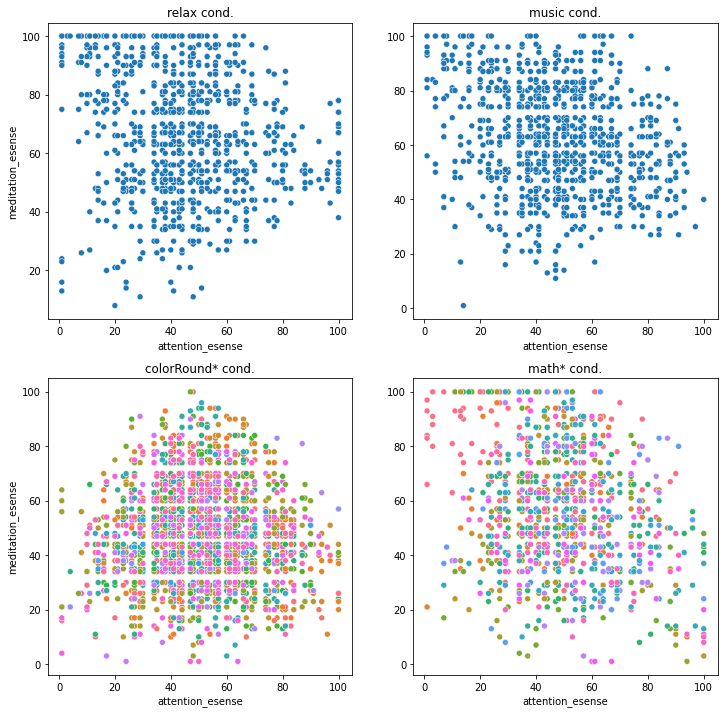

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

sns.scatterplot(data=cond_relax, y='meditation_esense', x='attention_esense', hue='label', ax=axes[0,0])
axes[0,0].set_title("relax cond.")

sns.scatterplot(data=cond_music, y='meditation_esense', x='attention_esense', hue='label', ax=axes[0,1])
axes[0,1].set_title("music cond.")
axes[0,1].set(ylabel=None)

sns.scatterplot(data=cond_task1, y='meditation_esense', x='attention_esense', hue='label', ax=axes[1,0])
axes[1,0].set_title("colorRound* cond.")

sns.scatterplot(data=cond_task2, y='meditation_esense', x='attention_esense', hue='label', ax=axes[1,1])
axes[1,1].set_title("math* cond.")
axes[1,1].set(ylabel=None)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].legend([],[], frameon=False)

plt.show()

From the four plot we can observe that for the relaxing conditions there indeed seems to be a tendency towards the upper left quadrant while the means still seems to lean somewhat to the center. For the two active conditions, however, there is no such salient tendency observable. For the `colorRound*` samples the distribution mainly hovers in the center with a slight tendency towards lower `meditation_esense` values. For the `math*` samples there are even a portion of data points lying at the very high end of the `meditation_esense` scale. 

Logically the same can be observed for the combined conditions `active_cond` and `passive_cond`

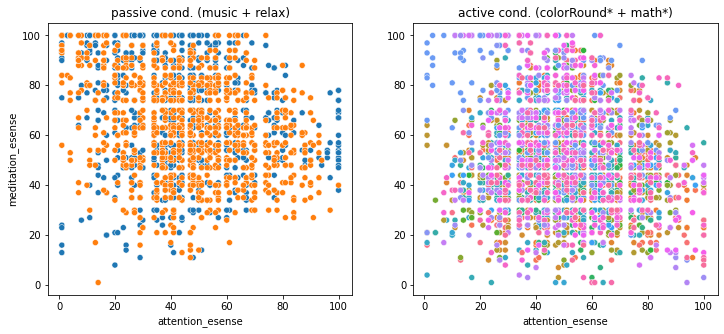

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.scatterplot(data=cond_passive, y='meditation_esense', x='attention_esense', hue='label', ax=axes[0])
axes[0].set_title("passive cond. (music + relax)")

sns.scatterplot(data=cond_active, y='meditation_esense', x='attention_esense', hue='label', ax=axes[1])
axes[1].set_title("active cond. (colorRound* + math*)")
axes[1].set(ylabel=None)

for i in range(axes.shape[0]):
    axes[i].legend([],[], frameon=False)

plt.show()

Another observation is that there are obviously _dead spots_ in the two algorithms for the ESENSE values. This is expressed by the grid-like gaps that can be observed in the scatter plots for both conditions. Why exactly these values are never produced by the algorithms cannot be uncovered because the algorithms have not been disclosed.

### Compating the distributions

To take a closer look at the value distribution we plotted histograms including mean and median of the four "individual" and the two combined conditions.

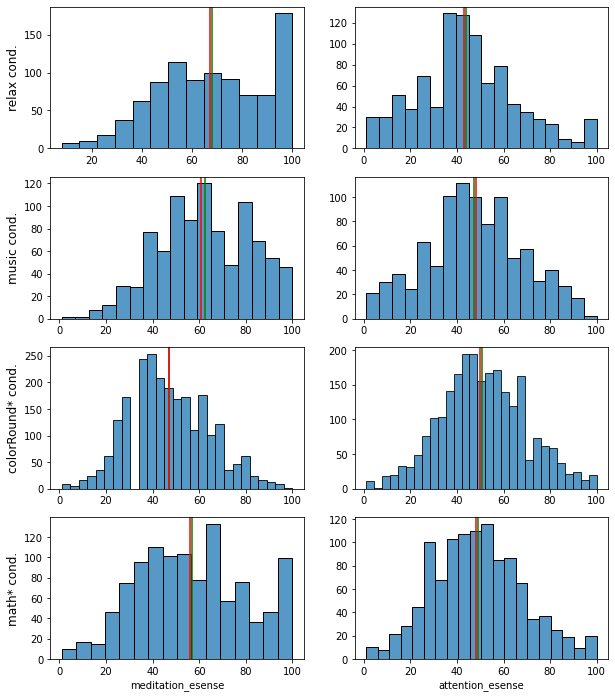

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,12))

sns.histplot(data=cond_relax["meditation_esense"], ax=ax[0,0])
ax[0,0].axvline(cond_relax["meditation_esense"].mean(), color='green')
ax[0,0].axvline(cond_relax["meditation_esense"].median(), color='red')
ax[0,0].set(xlabel=None)
ax[0,0].set_ylabel("relax cond.", size='large')

sns.histplot(data=cond_relax["attention_esense"], ax=ax[0,1])
ax[0,1].axvline(cond_relax["attention_esense"].mean(), color='green')
ax[0,1].axvline(cond_relax["attention_esense"].median(), color='red')
ax[0,1].set(ylabel=None)
ax[0,1].set(xlabel=None)

sns.histplot(data=cond_music["meditation_esense"], ax=ax[1,0])
ax[1,0].axvline(cond_music["meditation_esense"].mean(), color='green')
ax[1,0].axvline(cond_music["meditation_esense"].median(), color='red')
ax[1,0].set(xlabel=None)
ax[1,0].set_ylabel("music cond.", size='large')

sns.histplot(data=cond_music["attention_esense"], ax=ax[1,1])
ax[1,1].axvline(cond_music["attention_esense"].mean(), color='green')
ax[1,1].axvline(cond_music["attention_esense"].median(), color='red')
ax[1,1].set(ylabel=None)
ax[1,1].set(xlabel=None)

sns.histplot(data=cond_task1["meditation_esense"], ax=ax[2,0])
ax[2,0].axvline(cond_task1["meditation_esense"].mean(), color='green')
ax[2,0].axvline(cond_task1["meditation_esense"].median(), color='red')
ax[2,0].set(xlabel=None)
ax[2,0].set_ylabel("colorRound* cond.", size='large')

sns.histplot(data=cond_task1["attention_esense"], ax=ax[2,1])
ax[2,1].axvline(cond_task1["attention_esense"].mean(), color='green')
ax[2,1].axvline(cond_task1["attention_esense"].median(), color='red')
ax[2,1].set(ylabel=None)
ax[2,1].set(xlabel=None)

sns.histplot(data=cond_task2["meditation_esense"], ax=ax[3,0])
ax[3,0].axvline(cond_task2["meditation_esense"].mean(), color='green')
ax[3,0].axvline(cond_task2["meditation_esense"].median(), color='red')
ax[3,0].set_ylabel("math* cond.", size='large')

sns.histplot(data=cond_task2["attention_esense"], ax=ax[3,1])
ax[3,1].axvline(cond_task2["attention_esense"].mean(), color='green')
ax[3,1].axvline(cond_task2["attention_esense"].median(), color='red')
ax[3,1].set(ylabel=None)


plt.show()

These plots show that there is indeed a slight tendency toward the high end of the scale for the `meditation_esense` value in the two passive condition compared to the two active conditions. Although the mean foe the `math*` condition leans strongly to that side to. For the `attention_esense` value there can only very little differences in the means be observed accross all conditions. This picture solidifies when plotting the same for the two combined conditions:

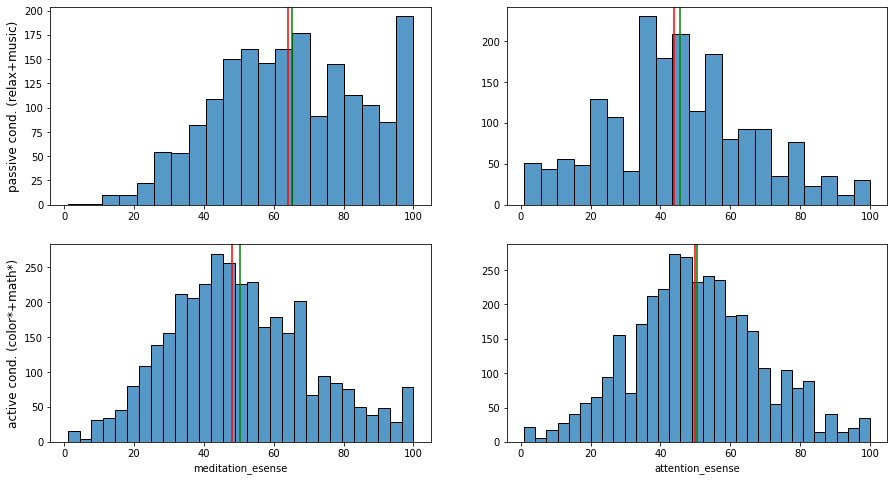

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

sns.histplot(data=cond_passive["meditation_esense"], ax=ax[0,0])
ax[0,0].axvline(cond_passive["meditation_esense"].mean(), color='green')
ax[0,0].axvline(cond_passive["meditation_esense"].median(), color='red')
ax[0,0].set(xlabel=None)
ax[0,0].set_ylabel("passive cond. (relax+music)", size='large')

sns.histplot(data=cond_passive["attention_esense"], ax=ax[0,1])
ax[0,1].axvline(cond_passive["attention_esense"].mean(), color='green')
ax[0,1].axvline(cond_passive["attention_esense"].median(), color='red')
ax[0,1].set(xlabel=None)
ax[0,1].set(ylabel=None)

sns.histplot(data=cond_active["meditation_esense"], ax=ax[1,0])
ax[1,0].axvline(cond_active["meditation_esense"].mean(), color='green')
ax[1,0].axvline(cond_active["meditation_esense"].median(), color='red')
ax[1,0].set_ylabel("active cond. (color*+math*)", size='large')

sns.histplot(data=cond_active["attention_esense"], ax=ax[1,1])
ax[1,1].axvline(cond_active["attention_esense"].mean(), color='green')
ax[1,1].axvline(cond_active["attention_esense"].median(), color='red')
ax[1,1].set(ylabel=None)

plt.show()

When plotting the histograms and means/medians for the active and the passive conditions combined we can see that the means of the `meditation_esense` differ between the two and that the means for `attention_esense` are closer together. The few instances in the `math*` condition that lie at the high end of the `meditation_esense` loose their significance when the two passive conditions are combined.

The shift in `meditation_esense` that we observed between the active and the passive conditions is congruent with the results from the whitepaper. It is a hint that the proprietary algortihm for computing could actually work. For the `attention_esense` value, however, this does not seem to be true as there is no significant shift in means observable. The whitepaper only talks about the attention meter in the introduction. The rest of the whitepaper only cares about the meditation meter. Since whitepapers by commercial entities are always an instrument of marketing, this is a hint that maybe the authors found the same as we and did not include because this would basically mean saying that the product partly doesn't work.

We also tried to perform Welch's t-test to compare the two means for the active and the passive combined conditions. We chose Welch's t-test because the sample sizes are not the same and also the variances of the four distributions are likely not the same. 

In [17]:
from scipy.stats import ttest_ind

# perform Welch's t-test
stats, pval = ttest_ind(cond_active["meditation_esense"], cond_passive["meditation_esense"], equal_var=True)
print(f"meditation_esense:  p = {pval}")

stats, pval = ttest_ind(cond_active["attention_esense"], cond_passive["attention_esense"], equal_var=True)
print(f"attention_esense:  p = {pval}")

meditation_esense:  p = 8.23059779329564e-138
attention_esense:  p = 1.2337096303997798e-17


The computed p-value for the `meditation_esense` means are much smaller than those for `attention_esense`, which would support our interpretation. However, both p-values are strangely small which lead us to the conclusion that there is an error in the choice of test or the application of the test itself.

## Pre-processing of EEG raw data

As mentioned there is also the field `raw_values` in the data set. According to the documentation this field contains the EEG raw values measured by the headband in the respective measurment period. Each instance are the measurments from a period of one second with a sampling rate or 512Hz. Each `raw_value` field contains an array with 512 values.

The datatype of the `raw_values` field actually is `string` and when looking at an example

In [18]:
data["raw_values"][2345]

'[19.0, 27.0, 41.0, 43.0, 26.0, -3.0, -17.0, -6.0, 6.0, 38.0, 75.0, 81.0, 55.0, 20.0, 11.0, 21.0, 26.0, 16.0, -3.0, -9.0, -7.0, 6.0, 34.0, 54.0, 57.0, 45.0, 42.0, 50.0, 56.0, 50.0, 48.0, 40.0, 32.0, 36.0, 39.0, 37.0, 35.0, 38.0, 43.0, 50.0, 54.0, 55.0, 52.0, 41.0, 39.0, 53.0, 61.0, 53.0, 49.0, 51.0, 51.0, 50.0, 35.0, 18.0, 23.0, 36.0, 24.0, 10.0, 12.0, 18.0, 20.0, 12.0, 9.0, 13.0, 21.0, 37.0, 52.0, 55.0, 45.0, 43.0, 53.0, 69.0, 74.0, 70.0, 72.0, 73.0, 70.0, 58.0, 43.0, 32.0, 23.0, 20.0, 16.0, 12.0, 17.0, 32.0, 50.0, 59.0, 66.0, 67.0, 71.0, 77.0, 85.0, 81.0, 64.0, 53.0, 43.0, 32.0, 19.0, 40.0, 76.0, 84.0, 58.0, 43.0, 41.0, 38.0, 37.0, 33.0, 28.0, 38.0, 43.0, 45.0, 49.0, 50.0, 53.0, 55.0, 51.0, 44.0, 39.0, 32.0, 24.0, 23.0, 32.0, 24.0, 11.0, 22.0, 40.0, 49.0, 57.0, 74.0, 75.0, 69.0, 66.0, 70.0, 70.0, 64.0, 59.0, 58.0, 56.0, 55.0, 53.0, 50.0, 58.0, 71.0, 64.0, 64.0, 66.0, 49.0, 42.0, 44.0, 55.0, 68.0, 72.0, 65.0, 54.0, 51.0, 54.0, 72.0, 88.0, 97.0, 82.0, 60.0, 49.0, 37.0, 34.0, 37.0, 44.0

We can see that the content of the `raw_values` field is a string representation of a Python array of floats. This means we can use Python's `eval` function to effortlessly convert the string into an actual array

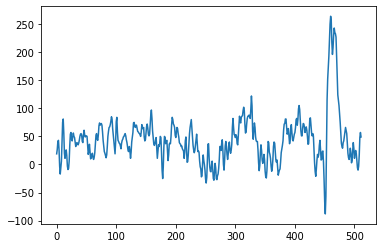

In [19]:
a = eval(data["raw_values"][2345])
plt.plot(a)
plt.show()

In the literature we have gone through when working on this project we have seen that often EEG signals are most often converted to **zscores** and also a lot of times these z-scores are **normalized**. This might be due to the fact the strength of the electrical signal can vary much inter-subject. Also the absolute values are not so much of interest as the waveform contained in the time series. By converting tpo z-scores it is possible to migrate to a standardized value range while perfectly conserving the waveform.

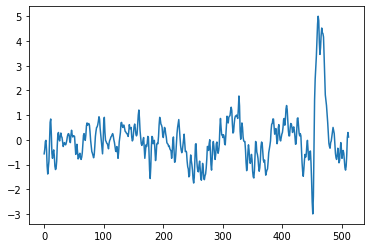

In [20]:
from scipy.stats import zscore

zs = zscore(a)
plt.plot(zs)
plt.show()

For a lot of data processing methods, also those we want to employ in the further course of this notebook, it is suitable or necessary to have the input data normalized to a range [0..1]. This is easily achieved by the following procedure

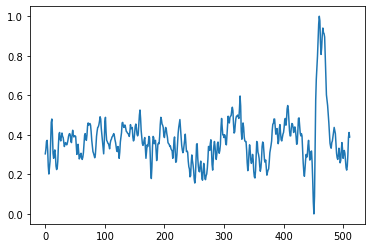

In [21]:
vmin = np.min(zs)
vmax = np.max(zs)
nzs = (zs - vmin) / (vmax - vmin)

plt.plot(nzs)
plt.show()

All values are now in the range [0..1]. We can also observe that the waveform was perfectly conserved during the conversion. In this form the EEG raw data is fit for further investigation. Because we will need several collections of converted raw data we define a function that takes a DataFrame and returns a list of numpy-arrays with the converted values. The function also take care of filtering out all the samples that have a `signal_quality` value >=128 which means that the quality of the measurment is to bad. The function also keeps track and prints before returning the percentage of samples dropped, to keep the user informed how much of the original data was discarded.

In [22]:
def raw_to_norm_zscore(df):
    filtered = []
    dropped = 0
    for _, row in df.iterrows():
        if row["signal_quality"] < 128:
            x = np.array(eval(row["raw_values"]))
            vmin = np.min(x)
            vmax = np.max(x)
            x = (x - vmin) / (vmax - vmin)
            filtered.append(x)
        else:
            dropped += 1
    print(f"{(dropped/len(df)):.2%} dropped")
    return filtered

## EEG: Average FFT-Spectra

We have seen that the esense values from the NeuroSky SDK are only of limited use for characterizing the measurements. Maybe classical EEG methods serve us better. So we tried to compute the FFT spectra for the active and the passive condition and then average them.

In the first step we needed to convert the `raw_values` values into actual numpy data using our converter function

In [23]:
print("converting samples from passive condition...", end="")
eegs_passive = raw_to_norm_zscore(cond_passive)
print("converting samples from active condition...", end="")
eegs_active = raw_to_norm_zscore(cond_active)

converting samples from passive condition...0.00% dropped
converting samples from active condition...0.00% dropped


Then we can iterate through all the samples and compute the FFT spectra. For this purpose we use the `getFFT` function from the tutorial.

In [24]:
def getFT(sig):

    # compute fft
    FFT = np.fft.fft(sig)
    FFT = np.abs(FFT)/len(sig) #normalise the frequencies to the number of time-points
    
    return FFT

In [25]:
from tqdm.notebook import tqdm

ffts_passive = [getFT(s) for s in eegs_passive]
ffts_active = [getFT(s) for s in eegs_active]

Let's sample some of the computed FFTS and take a look

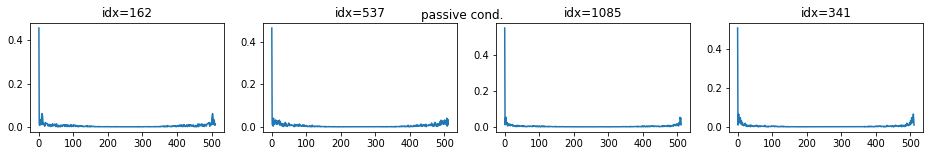

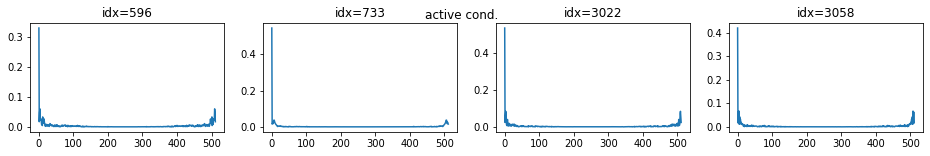

In [26]:
def sample_some(a, n, title):
    fig, ax = plt.subplots(ncols=n, nrows=1, figsize=(4*n, 2))
    for i in range(ax.shape[0]):
        idx = np.random.randint(len(a))
        ax[i].plot(a[idx]) 
        ax[i].set_title(f"idx={idx}")
    fig.suptitle(title)
            
sample_some(ffts_passive, 4, "passive cond.")
sample_some(ffts_active, 4, "active cond.")

We see not much because in each of the samples there is an overwhelming component at 0. So maybe we can see more if we discard the first component

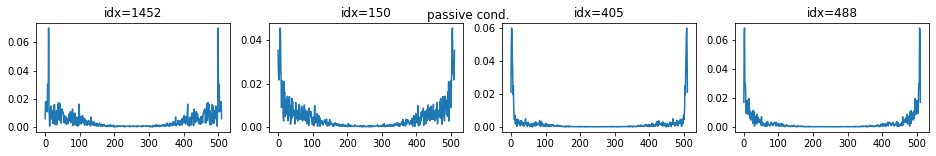

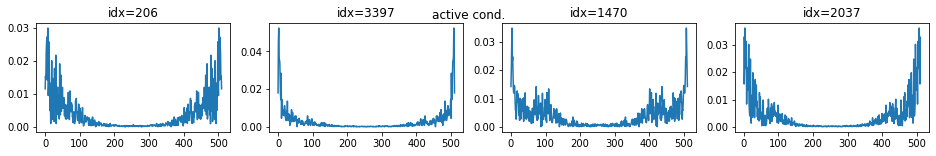

In [27]:
ffts_passive_clean = [a[1:] for a in ffts_passive]
ffts_active_clean = [a[1:] for a in ffts_active]

sample_some(ffts_passive_clean, 4, "passive cond.")
sample_some(ffts_active_clean, 4, "active cond.")

Now we can actually see a diference between the samples. However there is no real difference between the FTTs of the samples from the two conditions observable. For all samples a cumulation of frequencies at the low and the high end of the frequency spectrum can be observed.

If there is a significant difference between the two conditions, maybe it becomes visible when averaging the FFTs from the two conditions.

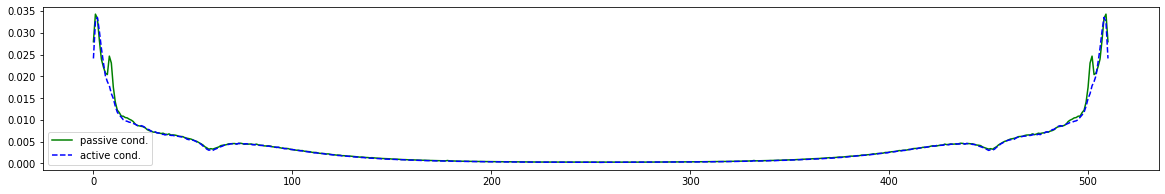

In [28]:
mean_fft_passive = np.mean(np.array(ffts_passive_clean), axis=0)
mean_fft_active = np.mean(np.array(ffts_active_clean), axis=0)

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(mean_fft_passive, "g-", label="passive cond.")
plt.plot(mean_fft_active, "b--", label="active cond.")
plt.legend()
plt.show()

It is obvious that the two averages of the FFT spectra of the two conditions are largly identical. This doesn't come a surprise in light of the fact that they have been computed from different samples from the same data set, a large overlap was to be expected. There is, however, an interesting difference in that the passive condition shows two spikes that the active condition does not have. We also observed that the two averages are oddly symmetrical with the symmetry axis at the center of the value range. But looking at the samples from the original FFTs we could see that they show the same kind of symmetry. This seems to be the case for all samples since the averages are also perfectly symmetrical.

## EEG: Finding blinking

To get a feeling of how the EEG signal look in general we sampled a few more raw signals using our `sample_some` function

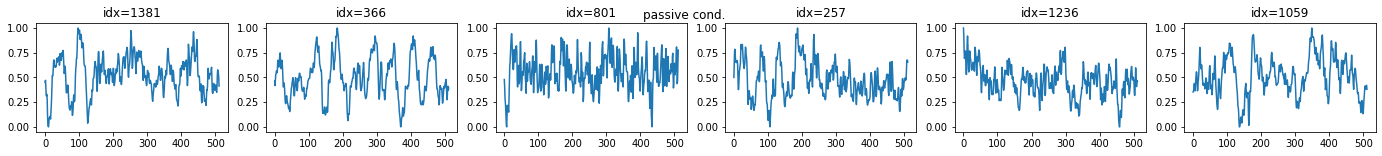

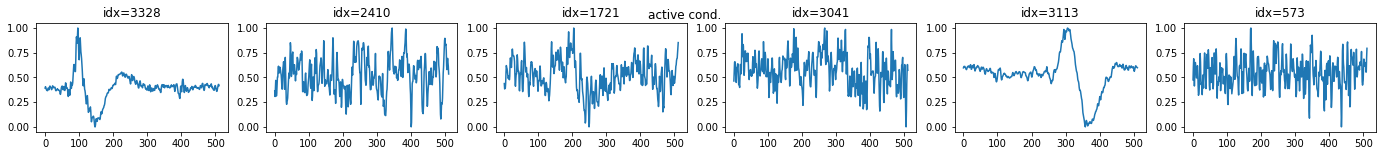

In [180]:
sample_some(eegs_passive, 6, "passive cond.")
sample_some(eegs_active, 6, "active cond.")

We observed that there are some instances of characteristic, large up-down events in the some of the EEG data. Having worked for several years at a sleep lab, Victoria instantly recognized them as eye blink events. This would make sense since the electrode of the NeuroSky device is placed on the forehead above the eyebrows. Being palced there it is very likely that strong muscle artifacts from blinking will be picked up too.

Fortunately part of the stimuli were also several instances where the participants were asked to blink several times. These were labeled `blink1-5`. If our hypothesis holds that the up-down-events are really eye blink events then we should find significantly more of them in the `blink*` samples than in the rest of the data.

We need to find instances of EEG `raw_values` that contain an occurence of this strong up-down event. We collected several examples by using the `sample_some` function. 

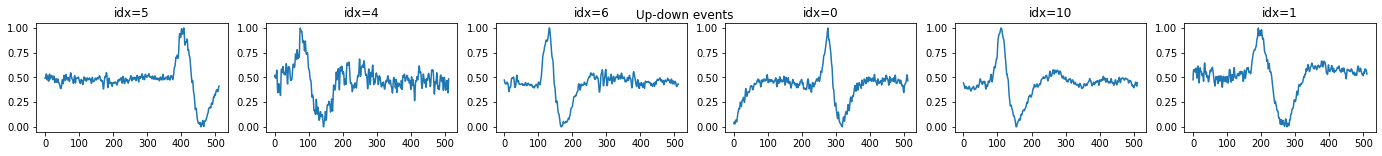

In [31]:
instances_active = [716, 1820, 1716, 2501, 1066, 264, 514, 716, 2682]
instances_passive = [243, 485, 483]
eegs_blink = [eegs_passive[idx] for idx in instances_passive]
eegs_blink += [eegs_active[idx] for idx in instances_active]

sample_some(eegs_blink, 6, "Up-down events")

In almost all cases the event's peaks are the minimum and maximum value in the sample. They also have a roughly the same length of 120-150. We decided to model this event using an ordinary Sine

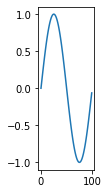

In [30]:
import math

t = np.linspace(0, math.pi*2, 100, False) 
blink_filter = np.array([0.0 for _ in range(len(t))])
for i in range(len(t)):
    blink_filter[i] = math.sin(t[i])
    
plt.rcParams["figure.figsize"] = (1,3)
plt.plot(blink_filter)
plt.show()

For testing we then collected also some instances of non-blink events

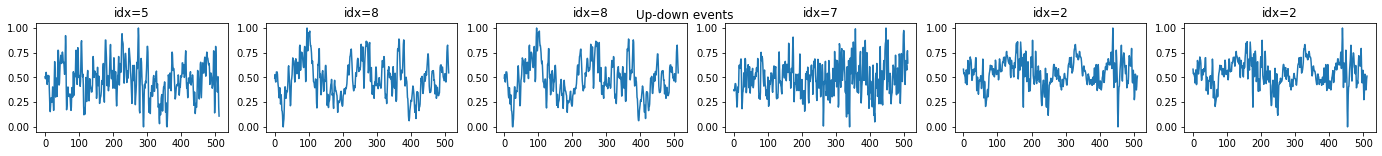

In [32]:
instances_active = [1272, 2374, 979, 3323, 585, 1702]
instances_passive = [555, 839, 1451, 562, 1836, 1467]
eegs_not_blink = [eegs_passive[idx] for idx in instances_passive]
eegs_not_blink += [eegs_active[idx] for idx in instances_active]

sample_some(eegs_not_blink, 6, "Up-down events")

For the detection of the event we slide the `blink_filter` template over the EEG signal and compute the mean squared distance

In [33]:
def msd(A, B):
    answer = []
    for i in range(0, len(A)-len(B)):
        answer.append( (np.square(A[i:i+len(B)] - B)).mean() )
    return np.array(answer)

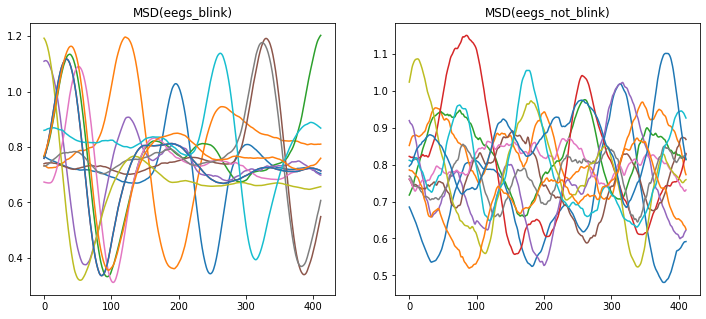

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
for i in range(len(eegs_blink)):
    answer = msd(eegs_blink[i], blink_filter)
    ax[0].plot(answer)
ax[0].set_title("MSD(eegs_blink)")
    
for i in range(len(eegs_not_blink)):
    answer = msd(eegs_not_blink[i], blink_filter)
    ax[1].plot(answer)
ax[1].set_title("MSD(eegs_not_blink)")
    
plt.show()

Comparing the answers of the `msd` function using our `blink_filer` template one can see that the minimum answer of the detector was <4.0 for all of the blink events. At the same time the answer for the non-blink samples was >=0.5. So we set the threshold for the detection of a blink to 3.8.

We test our detector by randomly sampling from the `eegs_active` data until we found 20 positives.

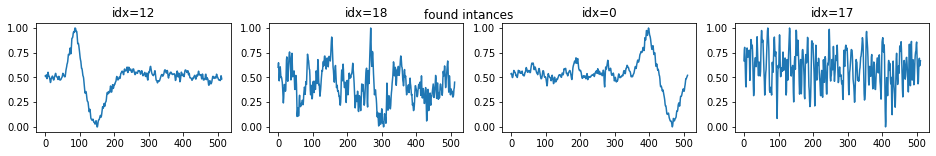

In [81]:
blink_threshold = 3.8
i=0
found = []
while i<20:
    idx = np.random.randint(len(cond_active))
    d = msd(eegs_active[idx], blink_filter)
    min_d = np.min(d)
    if min_d < blink_threshold:
        found.append(eegs_active[idx])
        i += 1
        
sample_some(found, 4, "found intances")

The plot shows that we found a lot of nice, clear up-down-events. However, we also found a considerable number of instances that are clearly notthe events we are looking for. This means that the detector can be much improved. Using another model function comes to mind, one that resembles our event more closely.

Despite this drawback we decided to go on with the `blink_filter` template we have. 

We then built a function that takes an array of EEG signals, a template and optionally a threshold and returns the number of EEG signals that prodced a detector answer with a minimum value smaller than the threshold

In [132]:
def count_matches(a, templ, threshold=0.38):
    blinks = 0
    for i in range(len(a)):
        d = msd(a[i], templ)
        min_d = np.min(d)
        if min_d < threshold:
            blinks += 1
    return blinks

We then used our `raw_to_norm_zscore` function to convert all the EEG signals labeled with `blink*` to normalized z-score

In [117]:
cond_blink = data[data["label"].str.startswith("blink", na=False)]
eegs_blink = raw_to_norm_zscore(cond_blink)
print(f"found {len(eegs_blink)} instances")

1.35% dropped
found 366 instances


Finally we ran the `count_matches` function for the EEG signal from the passive condition, the active condition and the blink condition

In [136]:
blink_threshold = 0.38

matches_passive = count_matches(eegs_passive, blink_filter, blink_threshold)
matches_active = count_matches(eegs_active, blink_filter, blink_threshold)
matches_blink = count_matches(eegs_blink, blink_filter, blink_threshold)

print(f"active cond.:  {(matches_active/len(eegs_active)):.2%}")
print(f"passive cond.: {(matches_passive/len(eegs_passive)):.2%}")
print(f"blink cond.:  {(matches_blink/len(eegs_blink)):.2%}")

active cond.:  15.62%
passive cond.: 8.20%
blink cond.:  21.86%


The results show more matches in the blink than in the active condition. Although we were expecting a lot more matches than ~22% this is consisten with our hypothesis. We also computed the percentage of matches for the passive condition that consists of the `relax` and the `music` condition for which the participants were instructed to close their eyes. Here we see a lot less matches. Those that are observable might be attributed to the samples labeled `blinkInstructions` that were also included in the blink condition because we were search for labels that started with `blink`.

## EEG: Variational Autoencoder on raw data

In [146]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy, mean_squared_error
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [166]:
# global parameters
epochs=30
batch_size = 512
original_dim = 512
latent_dim = 12

In [157]:
# take a sample from the distribution described by z_mean and z_log_var
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))      # random_normal has mean=0 and std=1.0 as default parameters
    return z_mean + K.exp(0.5 * z_log_var) * epsilon   # z_mean + sqrt(var) * epsilon

In [163]:
def build_encoder():
    inputs = Input(shape=(original_dim, ), name='encoder_input')
    x = Dense(2048, activation=LeakyReLU(alpha=0.3))(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    return encoder, z_mean, z_log_var

In [155]:
def build_decoder():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(2048, activation=LeakyReLU(alpha=0.3))(latent_inputs)
    x = Dense(original_dim)(x)
    decoder = Model(latent_inputs, x, name='decoder')
    decoder.summary()
    return decoder

In [164]:
# instantiate VAE model
encoder, z_mean, z_log_var = build_encoder()
decoder = build_decoder()
inputs = encoder.inputs
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# VAE loss = mse_loss + kl_loss
reconstruction_loss = mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

rmsprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer=rmsprop)
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2048)         1050624     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 12)           24588       dense_11[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 12)           24588       dense_11[0][0]                   
____________________________________________________________________________________________

In [168]:
x_train = np.array(raw_to_norm_zscore(data))
x_test = x_train

11.84% dropped


In [170]:
# train the VAE
model = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/30


TypeError: 'NoneType' object is not callable

The above error didn't happen in the python script. We have not found the bug yet. Please look at `mlp-vae.py` that is also contained in the repository.